In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import optimizers
import scipy.io
import numpy as np

Using TensorFlow backend.


## Loading data

In [2]:
def class_map():
    a = scipy.io.loadmat('./devkit/cars_meta.mat')
    res = {a['class_names'][0][i][0]: i for i in range(0, len(a['class_names'][0]))}
    res2 = {i : a['class_names'][0][i][0] for i in range(0, len(a['class_names'][0]))}
    return res,res2
c2i, i2c = class_map()
i2c = {key: item.split(' ')[0] for key, item in i2c.items()}
make = sorted(list(set(i2c.values())))
i2i = {key: make.index(item) for key, item in i2c.items()}

In [3]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
from keras.applications.imagenet_utils import preprocess_input

def load_data(image_paths, labels, crop_size):
    """
    Given list of paths, load images as one numpy array of shape
        (num_images, crop_size, crop_size, channel)
    :return X: image array
    "return y: one hot encoded labels
    """
    X = np.zeros((len(image_paths), crop_size, crop_size, 3))
    for i,path in enumerate(image_paths):
        X[i, :] = img_to_array(load_img(path, target_size=(crop_size, crop_size)))
    y = np_utils.to_categorical(labels, 196)
    return X, y

crop_size = 224
train_paths = []
val_paths = []
test_paths = []
train_labels = []
val_labels = []
test_labels = []

train_anno = scipy.io.loadmat('./devkit/cars_train_annos.mat')['annotations'][0]
for i in train_anno:
    #train_labels += [i2i[i[-2][0][0]-1]]
    train_labels += [i[-2][0][0]-1]
    train_paths += ['./cars_train/' + str(i[-1][0])]

val_labels = train_labels[6144:]
val_paths = train_paths[6144:]
train_labels = train_labels[:6144]
train_paths = train_paths[:6144]

In [4]:
#X_train, y_train = load_data(train_paths[:3000], train_labels[:3000], crop_size)
#X_val, y_val = load_data(val_paths, val_labels, crop_size)
X_test, y_test = load_data(val_paths, val_labels, crop_size)
#X_train = preprocess_input(X_train)
#X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [5]:
def generate_arrays(batch_size, crop_size = 224):
    sample_number = 6144
    while True:
        for i in range(0,sample_number,batch_size):
            if i + batch_size > sample_number:
                X_train, y_train = load_data(train_paths[i:], train_labels[i:], crop_size)
                X_train = preprocess_input(X_train)
            else:
                X_train, y_train = load_data(train_paths[i:i+batch_size], train_labels[i:i+batch_size], crop_size)
                X_train = preprocess_input(X_train)
            yield X_train, y_train


## Build Model

In [6]:
def get_model( output_dim ):
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer|
    predictions = Dense(output_dim, activation='softmax')(x)
    model = Model(input=base_model.input, output=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model
def get_model2(output_dim):
    vgg_model = VGG16( weights='imagenet', include_top=True )
    vgg_out = vgg_model.layers[-2].output #Last FC layer's output 
    softmax_layer = Dense(output_dim=output_dim, activation='softmax')(vgg_out)
    #Create new transfer learning model
    tl_model = Model( input=vgg_model.input, output=softmax_layer )

    #Freeze all layers of VGG16 and Compile the model
    for layer in vgg_model.layers[:-2]:
        layer.trainable = False
    #Confirm the model is appropriate
    #tl_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
    #tl_model.summary()
    return tl_model

In [68]:
model = get_model(196)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
convolution2d_283 (Convolution2D (None, None, None, 32 896         input_4[0][0]                    
____________________________________________________________________________________________________
batchnormalization_283 (BatchNor (None, None, None, 32 128         convolution2d_283[0][0]          
____________________________________________________________________________________________________
convolution2d_284 (Convolution2D (None, None, None, 32 9248        batchnormalization_283[0][0]     
___________________________________________________________________________________________

In [23]:
#only model
from keras.models import load_model
model = load_model('./model/New folder/test.99-2.01.hdf5')


## training

In [9]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='./model/test.{epoch:02d}-{val_loss:.2f}.hdf5', period = 5)

In [ ]:
#model.compile(optimizer='rmsprop',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.0001 , momentum=0.9, nesterov=True))
model.fit_generator(generate_arrays(batch_size=64),
                    validation_data=(X_test, y_test),
                    samples_per_epoch=6144, nb_epoch=1000,
                   callbacks=[checkpointer])

Epoch 1/1000
3072/6144 [==============>...............] - ETA: 36s - loss: 5.5135 - acc: 0.0062

## Predict

In [24]:
pred = model.predict(X_test)

In [50]:
pred[1].argmax()

9

In [11]:
s = [1,2,3,4]
s[:-2]

[1, 2]

In [14]:
def original(img):
    tmp = np.zeros_like(img)
    for i in range(3):
        tmp[:,:,i] = img[:,:,i] - img[:,:,i].min()
    return tmp.astype(np.uint8)

Hyundai


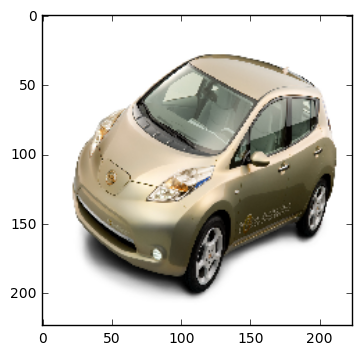

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
index = 1080
plt.imshow(original(X_test[index]))
print (make[pred[index].argmax()])

In [60]:
for i in range(1000,1500):
    print (make[pred[i].argmax()], i2c[y_test[i].argmax()])

Dodge Jeep
BMW BMW
Volkswagen Volkswagen
Ford Ford
Chevrolet Scion
GMC Chevrolet
Dodge Rolls-Royce
Chevrolet Chevrolet
Dodge GMC
BMW Bentley
BMW BMW
Dodge Ford
Nissan Bentley
Ford Ford
Chevrolet Ford
GMC Nissan
Ford Chevrolet
Ford Ford
Aston Ferrari
Land Land
Volkswagen Chevrolet
Chevrolet Chevrolet
Chevrolet Chevrolet
Chevrolet Bentley
Hyundai Acura
Dodge Dodge
Lamborghini Acura
Suzuki Suzuki
Audi BMW
Chevrolet Acura
BMW Acura
Hyundai Mercedes-Benz
Dodge Volvo
Ford Honda
Hyundai Hyundai
Chevrolet Mitsubishi
Hyundai Hyundai
Volkswagen Dodge
Chevrolet GMC
Toyota Toyota
BMW Lamborghini
Audi Chevrolet
BMW BMW
Honda Hyundai
Cadillac Hyundai
Mercedes-Benz Chrysler
Chevrolet Acura
Audi Chevrolet
BMW BMW
Chevrolet Chevrolet
Audi Audi
Nissan Cadillac
Hyundai Ford
Ferrari Ferrari
Lamborghini Lamborghini
Jeep Jeep
Hyundai Hyundai
Chevrolet smart
Lamborghini Lamborghini
Spyker Spyker
Chevrolet Chevrolet
BMW Audi
Chevrolet Infiniti
Hyundai Hyundai
Chevrolet Dodge
Chevrolet Ram
Hyundai Hyundai
Chev

In [57]:
y

2000